In [1]:
import pandas as pd
import pickle
import numpy as np 
import os
import networkx as nx
import matplotlib.pyplot as plt
import gzip

# Helper Functions

In [2]:
def gzip_readfile(filepath):
    with gzip.open(filepath, 'rb') as f:
        file_content = f.read()
    return(file_content)

# Data Preprocessing

In [9]:
# Comfitnet Social Networks
list_of_relevant_social_networks = ['Dolphin_social_network_Dolphins',
                                    'Email_network_Uni_R-V_Spain_Email_network_Uni_R-V_Spain',
                                    'Family_planning_in_Korea1',
                                    'Family_planning_in_Korea2',
                                    'High_school_dynamic_contact_networks_contact_list,_2011',
                                    'High_school_dynamic_contact_networks_contact_list,_2012',
                                    'Hollywood_film_music_Hollywood_film_music',
                                    'Kapferer_tailor_shop_Kapferer_tailor_shop_1',
                                    'Kapferer_tailor_shop_Kapferer_tailor_shop_2',
                                    'Les_Miserables_coappearances_Les_Miserables',
                                    'NCAA_college_football_2000_American_College_Football',
                                    'Norwegian_Board_of_Directors_net1mode_2011-08-01',
                                    'Zachary_Karate_Club_Zachary_karate_club_77',
                                    'Zachary_Karate_Club_Zachary_karate_club_78']

pickle_in = open('./data/Comfitnet/CommunityFitNet.pickle', "rb")
comfitdata = pickle.load(pickle_in, encoding ='latin1')

comfitdata_social = comfitdata[comfitdata['network_name'].isin(list_of_relevant_social_networks)]
comfitnet_social_subset = comfitdata_social[['network_name','nodes_id', 'edges_id']].reset_index(drop=True)

comfit_dict = dict()

for i in range(0,len(comfitnet_social_subset)):
    network_name = comfitnet_social_subset.network_name[i]
    edgelist = pd.DataFrame(comfitnet_social_subset.edges_id[i])
    comfit_dict[network_name] = edgelist



In [3]:
# Facebook
facebook = pd.read_csv('./data/Facebook/facebook-links.txt', sep='\t', header = None)
fb_with_timestamp = facebook.dropna().reset_index(drop=True)

In [4]:
from datetime  import datetime

def datestr_to_datetime(x):
    return datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

# where dates is some list of dates as a string... 
# vectorize the function
converttime = np.vectorize(datestr_to_datetime)

In [5]:
# Flixter
flixter_edges = pd.read_csv('./data/Flixter/flixter_edges.csv', header = None )

In [6]:
# Sociology Students
socistudent_matrix = pd.read_table('./data/Sociology Students of Groningen/stu98t6.txt', sep='\t', header = None).drop(0, axis =1)
socistudent_matrix = socistudent_matrix.replace(6, 0)
socistudent_matrix = socistudent_matrix.replace(5, 0)
socistudent_matrix = socistudent_matrix.replace(8, 0)
socistudent_matrix = np.matrix(socistudent_matrix)

In [7]:
# Linux Mailing List 
linux = pd.read_csv('./data/Linux Kernel Mailing List/out.lkml_person-thread_person-thread.txt', delim_whitespace = True, header = None)
linux.head()

,0,1,2,3
0,1,1,1,1139316299
1,1,1,1,1139316058
2,2,1,1,1139261931
3,3,1,1,1139256458
4,4,1,1,1139238713


In [8]:
# Within organisation social networks
within_organisation_dict = dict()
for i in os.listdir('./data/Within-Org_FBFriendships'):
    if 'csv' in i:
        print(i)
        x = pd.read_csv('./data/Within-Org_FBFriendships/' + str(i), header = None)
        within_organisation_dict[str(i)] = x
        print(str(type(within_organisation_dict)))

M2Anonymized.csv
<class 'dict'>
L1Anonymized.csv
<class 'dict'>
M1Anonymized.csv
<class 'dict'>
L2Anonymized.csv
<class 'dict'>
S2Anonymized.csv
<class 'dict'>
S1Anonymized.csv
<class 'dict'>


In [11]:
# Ugandan Village Dataset
# Within organisation social networks
ugandan_village_dict = dict()
for i in os.listdir('./data/Uganda Network Edgelists 2013/friendship'):
    if 'txt' in i:
        x = pd.read_csv('./data/Uganda Network Edgelists 2013/friendship/' + str(i), header = None)
        ugandan_village_dict['Ugandan Village '+ str(i)] = x
        print(str(type(ugandan_village_dict)))

<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


# Unweighted Networks Plot

In [78]:
#Create dictionaries
dict_of_networks = dict({'Flixter': flixter_edges.sample(n=10000), 
                      'Facebook': fb_with_timestamp.iloc[:,0:2],
                      'Linux Kernel Mailing List': linux.iloc[:,0:2],
                      'Dictionary of Within Org Friendships Network': within_organisation_dict,
                      'Dictionary of Comfit Networks': comfit_dict,
                      'Sociology Students of Groningen': socistudent_matrix,
          })

In [79]:
# Functions to generate all the plots in one plot

# Graph plotter plots the degree distributions given a graph and the corresponding network name
def graph_plotter(graph, network_name, weight = None):
    graph_degree = np.array(sorted([deg for id, deg in graph.degree()]))
    num_bins = 30
    counts, bin_edges = np.histogram (graph_degree, bins=num_bins, density=True)
    cdf = np.cumsum (counts)
    plt.plot(np.log(bin_edges[1:]), np.log(1-(cdf/cdf[-1])), label = str(network_name))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

# The next function iterates through dictionaries containing edgelists and adjacencymatrixes, generates graphs
# for each of the items in the dictionaries, and then calls the graph plotting function
def generate_log_complementary_cdf_all(dict_of_networks):
    for network_name, network_data in dict_of_networks.items():
        # Case when the value of the dictionary item is a pandas edgelist
        if isinstance(network_data, pd.DataFrame):
            print('Plotting Graph for ' + str(network_name))
            graph = nx.from_pandas_edgelist(network_data, 0, 1)
            graph_plotter(graph, network_name)
        
        # Case when the value of the dictionary item is a numpy matrix
        elif isinstance(network_data, np.matrix):
            print('Plotting Graph for ' + str(network_name))
            graph = nx.from_numpy_matrix(network_data)
            graph_plotter(graph, network_name)
        
        # Case when the value of the dictionary item is already a networkxGraph
        elif isinstance(network_data, nx.Graph):
            graph_plotter(network_data, network_name)
            
        # Case when the value of the dictionary item is a dictionary of pandas edgelist
        elif isinstance(network_data, dict):
            for sub_network_name, edgelist in network_data.items():
                print('Plotting Graph for ' + str(sub_network_name))
                graph = nx.from_pandas_edgelist(edgelist, 0, 1)
                graph_plotter(graph, sub_network_name)
        
        
    plt.xlabel('Log No. of edges')
    plt.ylabel('Log Complementary CDF (1-CDF)')
    plt.title('Degree Distribution of Various Networks (Snapshot)')
    plt.show()


Plotting Graph for Flixter
Plotting Graph for Facebook


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Plotting Graph for Linux Kernel Mailing List
Plotting Graph for M2Anonymized.csv
Plotting Graph for L1Anonymized.csv
Plotting Graph for M1Anonymized.csv
Plotting Graph for L2Anonymized.csv
Plotting Graph for S2Anonymized.csv
Plotting Graph for S1Anonymized.csv
Plotting Graph for Dolphin_social_network_Dolphins
Plotting Graph for Email_network_Uni_R-V_Spain_Email_network_Uni_R-V_Spain
Plotting Graph for Family_planning_in_Korea1
Plotting Graph for Family_planning_in_Korea2
Plotting Graph for High_school_dynamic_contact_networks_contact_list,_2011
Plotting Graph for High_school_dynamic_contact_networks_contact_list,_2012
Plotting Graph for Hollywood_film_music_Hollywood_film_music
Plotting Graph for Kapferer_tailor_shop_Kapferer_tailor_shop_1
Plotting Graph for Kapferer_tailor_shop_Kapferer_tailor_shop_2
Plotting Graph for Les_Miserables_coappearances_Les_Miserables
Plotting Graph for NCAA_college_football_2000_American_College_Football
Plotting Graph for Norwegian_Board_of_Directors_net

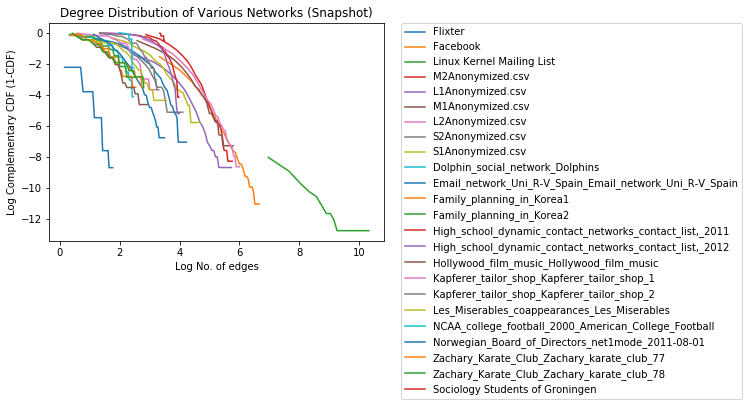

In [80]:
generate_log_complementary_cdf_all(dict_of_networks)

Plotting Graph for M2Anonymized.csv
Plotting Graph for L1Anonymized.csv
Plotting Graph for M1Anonymized.csv


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Plotting Graph for L2Anonymized.csv
Plotting Graph for S2Anonymized.csv
Plotting Graph for S1Anonymized.csv


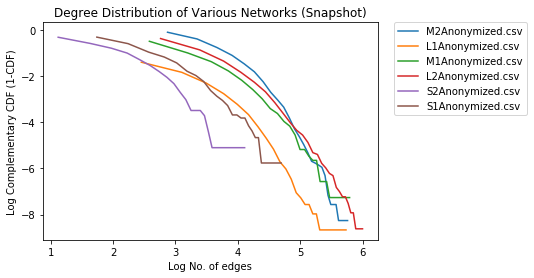

In [81]:
generate_log_complementary_cdf_all(within_organisation_dict)

Plotting Graph for Ugandan Village 15.txt
Plotting Graph for Ugandan Village 14.txt
Plotting Graph for Ugandan Village 16.txt
Plotting Graph for Ugandan Village 17.txt
Plotting Graph for Ugandan Village 13.txt
Plotting Graph for Ugandan Village 12.txt
Plotting Graph for Ugandan Village 10.txt
Plotting Graph for Ugandan Village 11.txt
Plotting Graph for Ugandan Village 9.txt
Plotting Graph for Ugandan Village 8.txt
Plotting Graph for Ugandan Village 5.txt
Plotting Graph for Ugandan Village 4.txt
Plotting Graph for Ugandan Village 6.txt
Plotting Graph for Ugandan Village 7.txt
Plotting Graph for Ugandan Village 3.txt
Plotting Graph for Ugandan Village 2.txt
Plotting Graph for Ugandan Village 1.txt


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


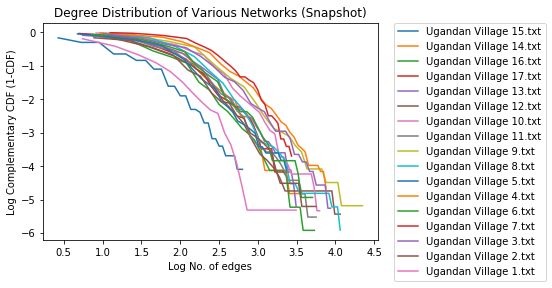

In [31]:
generate_log_complementary_cdf_all(ugandan_village_dict)

In [87]:
# Functions to generate all the plots in one plot

# Graph plotter plots the degree distributions given a graph and the corresponding network name
def graph_plotter_CDF(graph, network_name, weight = None):
    graph_degree = np.array(sorted([deg for id, deg in graph.degree()]))
    num_bins = 30
    counts, bin_edges = np.histogram (graph_degree, bins=num_bins, density=True)
    cdf = np.cumsum (counts)
    plt.plot(np.log(bin_edges[1:]), ((cdf/cdf[-1])), label = str(network_name))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

# The next function iterates through dictionaries containing edgelists and adjacencymatrixes, generates graphs
# for each of the items in the dictionaries, and then calls the graph plotting function
def generate_log_cdf_all(dict_of_networks):
    for network_name, network_data in dict_of_networks.items():
        # Case when the value of the dictionary item is a pandas edgelist
        if isinstance(network_data, pd.DataFrame):
            print('Plotting Graph for ' + str(network_name))
            graph = nx.from_pandas_edgelist(network_data, 0, 1)
            graph_plotter_CDF(graph, network_name)
        
        # Case when the value of the dictionary item is a numpy matrix
        elif isinstance(network_data, np.matrix):
            print('Plotting Graph for ' + str(network_name))
            graph = nx.from_numpy_matrix(network_data)
            graph_plotter_CDF(graph, network_name)
        
        # Case when the value of the dictionary item is already a networkxGraph
        elif isinstance(network_data, nx.Graph):
            graph_plotter_CDF(network_data, network_name)
            
        # Case when the value of the dictionary item is a dictionary of pandas edgelist
        elif isinstance(network_data, dict):
            for sub_network_name, edgelist in network_data.items():
                print('Plotting Graph for ' + str(sub_network_name))
                graph = nx.from_pandas_edgelist(edgelist, 0, 1)
                graph_plotter_CDF(graph, sub_network_name)
        
        
    plt.xlabel('Log No. of edges')
    plt.ylabel('CDF)')
    plt.title('Degree Distribution of Various Networks (Snapshot)')
    plt.show()


Plotting Graph for Flixter


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Plotting Graph for Facebook
Plotting Graph for Sociology Students of Groningen


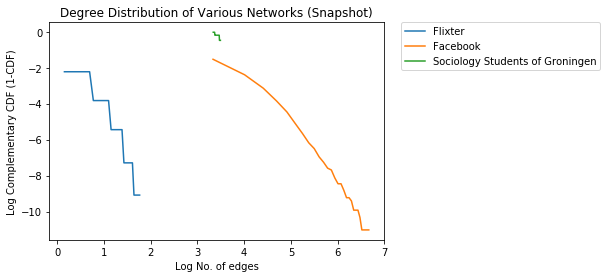

In [82]:
test_dict = {'Flixter': flixter_edges.sample(n=10000), 
                      'Facebook': fb_with_timestamp.iloc[:,0:2],
            'Sociology Students of Groningen': socistudent_matrix}

generate_log_complementary_cdf_all(test_dict)


Plotting Graph for Flixter
Plotting Graph for Facebook
Plotting Graph for Sociology Students of Groningen


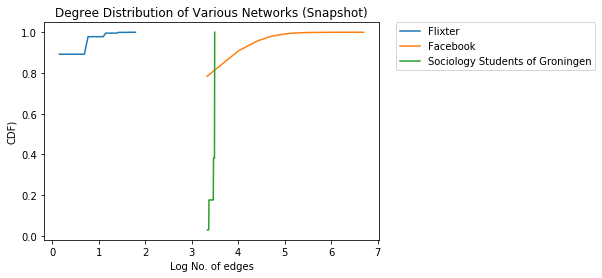

In [88]:
generate_log_cdf_all(test_dict)

# Weighted Networks

In [58]:
# Graph plotter plots the degree distributions given a graph and the corresponding network name
def weighted_graph_plotter(graph, network_name, weight = None):
    graph_degree = np.array(sorted([deg for id, deg in graph.degree(weight=weight)]))
    num_bins = 30
    counts, bin_edges = np.histogram (graph_degree, bins=num_bins, density=True)
    cdf = np.cumsum (counts)
    plt.plot(np.log(bin_edges[1:]), np.log(1-(cdf/cdf[-1])), label = str(network_name))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [77]:
#

school_contact_day_1 = nx.read_gexf('/Users/luajiongwei/Dropbox/LSE (Dropbox)/RA Docs/data/Contact Patterns - Primary School/sp_data_school_day_1_g.gexf_')
school_contact_day_2 = nx.read_gexf('/Users/luajiongwei/Dropbox/LSE (Dropbox)/RA Docs/data/Contact Patterns - Primary School/sp_data_school_day_2_g.gexf_')
dict_of_contacts = dict({'school_contact_day_1': school_contact_day_1, 
                         'school_contact_day_2': school_contact_day_2
                        })


j = 0 

for i in school_contact_day_1.edges(data=True):
    j +=1
    if j <= 5:
        print (i[0], i[1], i[2])
    
    

1789 1821 {'duration': 20, 'count': 1, 'id': '0'}
1789 1783 {'duration': 300, 'count': 13, 'id': '1'}
1789 1778 {'duration': 740, 'count': 23, 'id': '2'}
1789 1722 {'duration': 20, 'count': 1, 'id': '3'}
1789 1902 {'duration': 20, 'count': 1, 'id': '4'}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


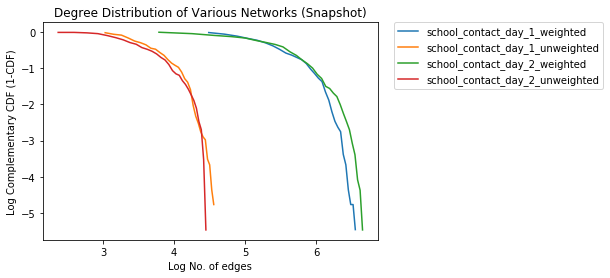

In [72]:
weighted_graph_plotter(school_contact_day_1,'school_contact_day_1_weighted', weight = 'count' )
weighted_graph_plotter(school_contact_day_1,'school_contact_day_1_unweighted')

weighted_graph_plotter(school_contact_day_2,'school_contact_day_2_weighted', weight = 'count' )
weighted_graph_plotter(school_contact_day_2,'school_contact_day_2_unweighted')

plt.xlabel('Log No. of edges')
plt.ylabel('Log Complementary CDF (1-CDF)')
plt.title('Degree Distribution of Various Networks (Snapshot)')
plt.show()